# Ensemble Methods: Simple Averaging and Bootstrap Aggregating (aka Bagging)

# Objectives

- Use `sklearn` to build voting models
- Describe the algorithm of bagging
- Describe the differences among simple bagging, random forest, and extra trees algorithms
- Implement bagging models in `sklearn`

# Ensemble Methods

Because many heads are better than one!

<img width=50% src='images/captain_planet.jpg'/>

> "With our powers combined..."

Ensemble Methods take advantage of the "wisdom of crowds" where the average of multiple independent estimates is usually more consistently accurate than the individual estimates.

## Three Varieties, Three Levels of Randomization

We'll talk about two kinds of ensemble methods today:

1. **Simple Averaging**: Train multiple model, then average
2. **Bagging**: aka *B*ootstrap *AGG*regation - letting each model only see part of the data to train, then aggregating the results
    - For trees, we'll specifically focus on two bagging techniques:
    1. **Random Forest**: Choose a random set of features at each decision point
    2. **Extra Trees**: Choose a path at random!

## Data Preparation for Examples

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('data/cars.csv', na_values = ' ')
df.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350.0,165,4209.0,12,1972,US.
1,31.9,4,89.0,71,1925.0,14,1980,Europe.
2,17.0,8,302.0,140,3449.0,11,1971,US.
3,15.0,8,400.0,150,3761.0,10,1971,US.
4,30.5,4,98.0,63,2051.0,17,1978,US.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           261 non-null    float64
 1    cylinders    261 non-null    int64  
 2    cubicinches  259 non-null    float64
 3    hp           261 non-null    int64  
 4    weightlbs    258 non-null    float64
 5    time-to-60   261 non-null    int64  
 6    year         261 non-null    int64  
 7    brand        261 non-null    object 
dtypes: float64(3), int64(4), object(1)
memory usage: 16.4+ KB


In [4]:
df.isna().sum().sum()

5

### Defining Our Problem

Let's see if we can predict whether a car is American or not.

In [5]:
df[' brand'].value_counts()

 US.        162
 Japan.      51
 Europe.     48
Name:  brand, dtype: int64

In [6]:
df['target'] = df[' brand'] == ' US.'

In [7]:
df.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand,target
0,14.0,8,350.0,165,4209.0,12,1972,US.,True
1,31.9,4,89.0,71,1925.0,14,1980,Europe.,False
2,17.0,8,302.0,140,3449.0,11,1971,US.,True
3,15.0,8,400.0,150,3761.0,10,1971,US.,True
4,30.5,4,98.0,63,2051.0,17,1978,US.,True


### Fix Columns with Missing Values

In [8]:
X = df.drop(['target', ' brand'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
si = SimpleImputer()

si.fit(X_train)

X_tr_im = si.transform(X_train)
X_te_im = si.transform(X_test)

## Version 1: Simple Averaging

> Each model uses the same data to train and then we "vote" to make a prediction

### Simple Ensemble Techniques - How do we use the wisdom of the crowd? 

1. **Max Voting** - The max voting method is generally used for classification problems. In this technique, multiple models are used to make predictions for each data point. The predictions by each model are considered as a ‘vote’. The predictions which we get from the majority of the models are used as the final prediction.

> For example, when you asked 5 of your colleagues to rate your movie (out of 5); we’ll assume three of them rated it as 4 while two of them gave it a 5. Since the majority gave a rating of 4, the final rating will be taken as 4. You can consider this as taking the mode of all the predictions.

2. **Averaging** - Similar to the max voting technique, multiple predictions are made for each data point in averaging. In this method, we take an average of predictions from all the models and use it to make the final prediction. Averaging can be used for making predictions in regression problems or while calculating probabilities for classification problems.

3. **Weighted Averaging** - This is an extension of the averaging method. All models are assigned different weights defining the importance of each model for prediction. For instance, if two of your colleagues are movie critics, while others have no prior experience in this field, then the answers by these two friends are given more importance as compared to the other people.

[User Guide!](https://scikit-learn.org/stable/modules/ensemble.html)


### Model 1 - Logistic Regression

In [11]:
# Instantiate and fit our logreg
lr = LogisticRegression(max_iter=1000, random_state=42)

lr.fit(X_tr_im, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [16]:
# Check our scores
scores = cross_val_score(estimator=lr, X=X_tr_im,
                         y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.8462 (+/- 0.0699)


In [13]:
# Test score
lr.score(X_te_im, y_test)

0.8939393939393939

### Model 2 - KNN

In [17]:
# Instantiate and fit a knn with k=3
knn = KNeighborsClassifier(3)

knn.fit(X_tr_im, y_train)

KNeighborsClassifier(n_neighbors=3)

In [18]:
# Check our scores
scores = cross_val_score(estimator=knn, X=X_tr_im,
                y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.7692 (+/- 0.0205)


In [19]:
# Test score
knn.score(X_te_im, y_test)

0.7878787878787878

### Model 3 - Decision Tree

In [20]:
# Instantiate and fit an untuned decision tree
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_tr_im, y_train)

DecisionTreeClassifier(random_state=42)

In [21]:
# Check our scores
scores = cross_val_score(estimator=dt, X=X_tr_im,
                         y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.8718 (+/- 0.0417)


In [22]:
# Test score
dt.score(X_te_im, y_test)

0.7878787878787878

### Averaging the Models

#### Building a `VotingClassifier`

Of course there's an SKLearn class for that!

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [23]:
# Need to import!
from sklearn.ensemble import VotingClassifier

In [25]:
# Instantiate and fit our VotingClassifier
avg = VotingClassifier([
    ("logreg", lr),
    ('knn-3', knn),
    ('dt', dt)
])

avg.fit(X_tr_im, y_train)

VotingClassifier(estimators=[('logreg',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('knn-3', KNeighborsClassifier(n_neighbors=3)),
                             ('dt', DecisionTreeClassifier(random_state=42))])

In [26]:
# Check our scores
scores = cross_val_score(estimator=avg, X=X_tr_im,
                         y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.8718 (+/- 0.0417)


In [27]:
# Test score
avg.score(X_te_im, y_test)

0.8636363636363636

#### Weighted Averaging with the `VotingClassifier`

> Even if the vote is 50-50, you'd probably side with the "smart" ones more

This meta-estimator is not as good as one of our base estimators, so in this case the averaging did not work very well. Realizing that the logistic regression is performing better than the decision tree and the k-nearest-neighbors model, however, we might decide to build a meta-estimator by calculating a **weighted average** of the base estimators' predictions. And we can weight, or bias, this estimator in favor of the best-performing base estimator. Suppose we weight the logistic regression 50%, the knn model 25%, and the decision tree 25%:

In [31]:
# Instantiate and fit, this time with the weights outlined above
w_avg = VotingClassifier([
    ('logreg', lr),
    ('knn-3', knn),
    ('dt', dt)
], weights=[.5, .25, .25], voting='soft')

w_avg.fit(X_tr_im, y_train)

VotingClassifier(estimators=[('logreg',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('knn-3', KNeighborsClassifier(n_neighbors=3)),
                             ('dt', DecisionTreeClassifier(random_state=42))],
                 voting='soft', weights=[0.5, 0.25, 0.25])

In [32]:
# Check our scores
scores = cross_val_score(estimator=w_avg, X=X_tr_im,
                         y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.8718 (+/- 0.0552)


In [33]:
# Test score
w_avg.score(X_te_im, y_test)

0.8939393939393939

## Version 2: Bagging

A single decision tree will often overfit your training data. Let's see if we have evidence of that in the current case:

In [34]:
# Scoring our earlier dt on train
dt.score(X_tr_im, y_train)

1.0

#### 🧠 Knowledge Check: What is this score? And why is it equal to 1?

- ACCURACY! And it's equal to 1 on training data cause this model is hella overfit


In [35]:
scores = cross_val_score(estimator=dt, X=X_tr_im,
                         y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.8718 (+/- 0.0417)


In [36]:
dt.score(X_te_im, y_test)

0.7878787878787878

But it's often better to do something else: Plant another tree!

Of course, if a second tree is going to be of any value, it has to be *different* from the first. Here's a good algorithm for achieving that:

## Bootstrap Aggregation

The idea behind **bagging** is combining the results of multiple models (for instance, all decision trees) to get a generalized result. Here’s a question: If you create all the models on the same set of data and combine it, will it be useful? There is a high chance that these models will give the same result since they are getting the same input. So how can we solve this problem? One of the techniques is bootstrapping.

**Bootstrapping** is a sampling technique in which we create subsets of observations from the original dataset, with replacement. The size of the subsets is the same as the size of the original set.

**Bagging (or Bootstrap Aggregating)** technique uses these subsets (bags) to get a fair idea of the distribution (complete set). The size of subsets created for bagging may be less than the original set.
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image20-768x289.png)


Multiple subsets are created from the original dataset, selecting observations with replacement.
A base model (weak model) is created on each of these subsets.
The models run in parallel and are independent of each other.
The final predictions are determined by combining the predictions from all the models.
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/Screenshot-from-2018-05-08-13-11-49-768x580.png)

### SIMPLE Bagging with `sklearn`

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In [37]:
# Import!
from sklearn.ensemble import BaggingClassifier

In [65]:
# Instatiate and fit a BaggingClassifier with n_estimators=100
# Note the base esimator is by default a decision tree
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
    n_estimators=100, max_samples=.75, random_state=42)

bag.fit(X_tr_im, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  max_samples=0.75, n_estimators=100, random_state=42)

In [66]:
# Check our scores
scores = cross_val_score(estimator=bag, X=X_tr_im,
                         y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.8718 (+/- 0.0340)


In [67]:
# Test score
bag.score(X_te_im, y_test)

0.8939393939393939

### Fitting a Random Forest

Let's add an extra layer of randomization: Instead of using *all* the features of my model to optimize a branch at each node, I'll just choose a subset of my features.

That's the essence of a random forest model. Note that there are now **two** levels of random sampling happening: To build a new tree, I'll be taking only some of my data points; and at any branching point in a tree, I'll be using only some of my features to determine the split.

#### Steps:

1. Save a portion of data for validation (**out-of-bag**), the rest for training (**bag**)
2. The data for training (**bag**) is then split up by randomly selecting predictors
3. Grow/train your tree with the training data using just those features
4. Use our validation set (**out-of-bag**), take out the columns used in our tree from the previous step, and predict using the tree & this *out-of-bag* data
5. Compare on how well the tree did *out-of-bag error*
6. Repeat to make new trees and use the result to "vote" for the final decision

### Random Forest with `sklearn`

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [68]:
# Import!
from sklearn.ensemble import RandomForestClassifier

In [89]:
# Instantiate and fit a RandomForestClassifier

rfc = RandomForestClassifier(random_state=93, max_depth=5)

rfc.fit(X_tr_im, y_train)

RandomForestClassifier(max_depth=5, random_state=93)

In [90]:
rfc.score(X_tr_im, y_train)

0.9948717948717949

In [91]:
# Check our scores
scores = cross_val_score(estimator=rfc, X=X_tr_im,
                         y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.8718 (+/- 0.0417)


In [95]:
# Test score
score = rfc.score(X_te_im, y_test)
score

0.9090909090909091

### Cool Features of Random Forests

#### Investigate Your Forest 🌲🌲👀🌲🌲

We can check out our trained estimators after training the ensemble. This isn't necessarily unique to random forests, but since the base model is always a decision tree we can really investigate how the model is working!

In [98]:
from sklearn.tree import plot_tree

100


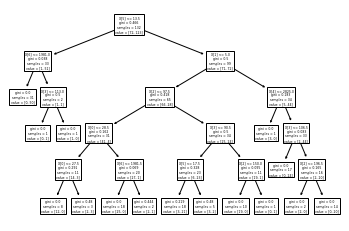

In [100]:
model_estimators = rfc.estimators_ 
print(len(model_estimators))
plot_tree(model_estimators[0]);

In [101]:
print(f'Overall model\'s score was {score:.3f}')
print('='*70)

for model in model_estimators[-5:]:
    display(model)
    model_score = model.score(X_te_im, y_test)
    print(f'\tModel gave score of {model_score:.3f}')

Overall model's score was 0.909


DecisionTreeClassifier(max_depth=5, max_features='auto',
                       random_state=1423826995)

	Model gave score of 0.864


DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=338485344)

	Model gave score of 0.848


DecisionTreeClassifier(max_depth=5, max_features='auto',
                       random_state=1507766687)

	Model gave score of 0.742


DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=6324909)

	Model gave score of 0.712


DecisionTreeClassifier(max_depth=5, max_features='auto',
                       random_state=1410910058)

	Model gave score of 0.773


#### Feature Importances

We can use [`.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) property of the trained model to get an idea of what features mattered the most

In [106]:
feat_import = {name: imp for name, imp in zip(X_train.columns, rfc.feature_importances_)}
feat_import

{'mpg': 0.1120439179122671,
 ' cylinders': 0.14315108505112964,
 ' cubicinches': 0.34518720493721144,
 ' hp': 0.11204619696880583,
 ' weightlbs': 0.17174211863242275,
 ' time-to-60': 0.0477848864323002,
 ' year': 0.06804459006586315}

### Extremely Randomized Trees (Extra Trees)

Sometimes we might want even one more bit of randomization. Instead of always choosing the *optimal* branching path, we might just choose a branching path at random. If we're doing that, then we've got extremely randomized trees.

There are now **three** levels of randomization: sampling of data, sampling of features, and random selection of branching paths.

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)

In [107]:
# Import!
from sklearn.ensemble import ExtraTreesClassifier

In [114]:
# Instantiate and fit an ExtraTreesClassifier
etc = ExtraTreesClassifier(random_state=42, max_depth=5)

etc.fit(X_tr_im, y_train)

ExtraTreesClassifier(max_depth=5, random_state=42)

In [115]:
# Check our scores
scores = cross_val_score(estimator=etc, X=X_tr_im,
                         y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.8718 (+/- 0.0429)


In [116]:
# Test score
etc.score(X_te_im, y_test)

0.9090909090909091

## Pros and Cons of Random Forests 

(FYI - Random Forests are the most common of the techniques we've explored today, hence the focus here! Many of these pros/cons would also apply to other ensemble or bagging techniques)

**Pros:**
* Strong performance -- because this is an ensemble algorithm, the model is naturally resistant to noise and variance in the data, and generally tends to perform quite well.

* Interpretability: each tree in the random forest is a Glass-Box Model (meaning that the model is interpretable, allowing us to see how it arrived at a certain decision)

**Cons:**
* Computational complexity: On large datasets, the runtime can be quite slow compared to other algorithms.

* Memory usage: Random forests tend to have a larger memory footprint that other models. It's not uncommon to see random forests that were trained on large datasets have memory footprints in the tens, or even hundreds of MB.

* Interpretability: although each tree is a Glass-Box Model and quite interpretable, it can be harder to grasp exactly what's happening in aggregate without some extra work (and the `feature_importances_` given by random forest models are notoriously bad/unreliable!)

    - Additional details about why we don't trust random forest feature importances: https://explained.ai/rf-importance/

-----

# Level Up: Stacking

#### Meta-Classifier/Meta-Regressor

- First, we ask several different models to make predictions about the target
- Rather than taking a simple average or vote to determine the outcome, feed these results into a final model that makes the prediction based on the other models’ predictions
- If it seems like we are approaching a neural network...you are correct!

Remember weighted averaging? Stacking is about using DS models to estimate those weights for us. This means we'll have one layer of base estimators and another layer that is "**trained to optimally combine the model predictions to form a new set of predictions**". See [this short blog post](https://blogs.sas.com/content/subconsciousmusings/2017/05/18/stacked-ensemble-models-win-data-science-competitions/) for more.

## Initial Data Prep

In [117]:
import xlrd
import os

wb = xlrd.open_workbook('data/Sales Report.xls',
                        logfile=open(os.devnull, 'w'))

sales = pd.read_excel(wb)
sales = sales.dropna()

In [118]:
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [119]:
sales.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code             float64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [120]:
sales['Category'].value_counts()

Office Supplies    6020
Furniture          2119
Technology         1844
Name: Category, dtype: int64

In [121]:
sales['Sub-Category'].value_counts()

Binders        1523
Paper          1368
Furnishings     957
Phones          888
Storage         845
Art             795
Accessories     773
Chairs          616
Appliances      465
Labels          364
Tables          319
Envelopes       253
Bookcases       227
Fasteners       217
Supplies        190
Machines        115
Copiers          68
Name: Sub-Category, dtype: int64

In [122]:
X_num = sales[['Discount', 'Profit']].columns
X_cat = sales[['Category', 'Sub-Category']].columns

In [123]:
X = sales[['Discount', 'Profit', 'Category', 'Sub-Category']]
y = sales['Sales']

## Splitting

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Setting Up a Pipeline

In [134]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [131]:
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
])

In [132]:
pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
])

In [137]:
pp.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['Discount', 'Profit'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['Category', 'Sub-Category'], dtype='object'))])

In [138]:
X_tr_pp = pp.transform(X_train)

In [141]:
X_test_pp = pp.transform(X_test)

In [143]:
# Comparison

linreg = LinearRegression()

linreg.fit(X_tr_pp, y_train)

print(f"Train Score: {linreg.score(X_tr_pp, y_train)}")
print(f"Test Score: {linreg.score(X_test_pp, y_test)}")

Train Score: 0.36198304078636423
Test Score: 0.42942244281549513


## Setting Up a Stack

In [139]:
estimators = [
    ('lr', LinearRegression()),
    ('knn', KNeighborsRegressor()),
    ('rt', DecisionTreeRegressor())
]

sr = StackingRegressor(estimators)

In [140]:
sr.fit(X_tr_pp, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('knn', KNeighborsRegressor()),
                              ('rt', DecisionTreeRegressor())])

In [142]:
print(f"Train Score: {sr.score(X_tr_pp, y_train)}")
print(f"Test Score: {sr.score(X_test_pp, y_test)}")

Train Score: 0.8433894891447702
Test Score: 0.8112034205668603


## Comparison with Base Estimators

In [144]:
lr = LinearRegression().fit(X_tr_pp, y_train)
print(f"Train Score: {lr.score(X_tr_pp, y_train)}")
print(f"Test Score: {lr.score(X_test_pp, y_test)}")

Train Score: 0.36198304078636423
Test Score: 0.42942244281549513


In [145]:
knn = KNeighborsRegressor().fit(X_tr_pp, y_train)
print(f"Train Score: {knn.score(X_tr_pp, y_train)}")
print(f"Test Score: {knn.score(X_test_pp, y_test)}")

Train Score: 0.8088770993187154
Test Score: 0.7963215988357311


In [146]:
rt = DecisionTreeRegressor().fit(X_tr_pp, y_train)
print(f"Train Score: {rt.score(X_tr_pp, y_train)}")
print(f"Test Score: {rt.score(X_test_pp, y_test)}")

Train Score: 0.9955666197715463
Test Score: 0.2454185100576537
